# 第8章 員が構造をデータから推測する因果探索

## 8.1 因果探索の概要

### 8.1.1 因果探索の位置づけ

[第2章](../chap1_4/chap2.ipynb#25-因果効果推定のためのグラフ)ではDAGを用いて因果を考えて来たが、事前知識がな、系が複雑などDAGが描けない場合、因果探索を行う。

因果探索では、因果の方向と強さの推定を行う。

![図8.3](images/chap8/image.png)

実世界の活用例

Amazonのプライムデーで1時間の障害(2018年)。最大1億ドルの売上損失が発生した可能性。因果探索を使えば障害の原因をすぐに特定、もしくは防止できる。

米国では因果探索を用いてCOVID-19のワクチン接種をためらう要因を分析し対策が取られていた。

### 8.1.2 グラフィカルモデルとベイジアンネットワーク

員が探索ではグラフィカルモデルが欠かせない。

因果探索で用いるグラフィカルモデル

* 有向グラフ

  * ベイジアンネットワーク

    状態A、Bがあるときに、AからBに遷移する確率を示す。因果関係ではないので別途検証する必要があることに注意

    * 静的: 時系列を考慮しない([8.2節](#82-因果探索手法の全体像))
    * 動的: 時系列を考慮する([8.4節](#84-時系列を伴う因果探索の全体像))
* 無向グラフ

  * ボルツマンマシン(Boltzman Machine)

ベイジアンネットワークの定義

* $|X_1, X_2 \ldots X_n|$: ノードの集合$V$
* $E$: エッジの集合
* $parent(X_i)$: $X_i$親ノード

ベイジアンネットワークは双方向矢線のない有向非巡回グラフ$G=(V, E)$なので、次のように表現する

$$
P(X_1, X_2 \ldots X_n) = \prod_{i=1}^n P(X_i | parent(X_i))
$$

つまり、同時分布(左項)が親ノードで条件付けられた確率の積(右項)として記述できる

ベイジアンネットワークの特性として、親と子の依存関係を各要素に分解できる分解特性がある

例: 雲ができた後に地面に水たまりができる確率

* $P(A)$: 雲が発生する確率
* $P(B|A)$: 雲が発生したときに雨が降る確率
* $P(C|B)$: 雨が降ったあとに水たまりができる確率

$水たまりができる確率 = P(C|B)P(B|A)P(A)$

### 8.1.3 ベイジアンネットワークの特徴

グラフィカルモデルを用いることによる、各変数の依存関係や構造に関する解釈性と説明可能性があるため、原因の深堀りや構造化が可能

### 8.1.4 ベイジアンネットワークから因果ダイアグラムへ

ベイジアンネットワークは変数の依存関係を示すが因果関係は含まない。そこから因果関係を含むグラフを作成するには以下を用いる。

![図8.9](images/chap8/image-1.png)

1. 因果モデル

   決定論的な関数方程式で因果関係を表現する

   * $f_i$: 任意の関数
   * $\epsilon_i$

   $$
   X_i = f_i (parent(X_i), \varepsilon_i) \ (i=1,\ldots, n)
   $$
2. 因果ダイアグラム

   因果モデルをもとに、親ノード($parent(X_i)$)から子ノード($X_i$)への矢印を引きグラフを描いたもの

   * ノード: 対象の確率変数を表す
   * エッジの方向: 直接的に影響を与えうる関係性
     ![図8.10](images/chap8/image-2.png)

このような因果ダイアグラムを作る際などに、相関や依存関係から因果関係を推定するには、以下の因果仮定(Causal assumptions)を置いて因果探索を行う必要がある。

1. 因果マルコフ条件(Causal Markov Condition)

   ノード$X_i \in X$は、親ノードで条件付けられた場合、それが直接間接的にかかわらず、非子孫の他のノード$X_i \in X$と条件付き独立。言い換えると、親ノード経由でのみたどり着けるノード(エッジ方向は無視)とは条件付き独立ということ

   この条件によって推論の対象範囲を絞り込める
2. 忠実性(Faithfulness)

   任意のノード間において、d分離以外には統計的独立関係が成り立たないこと

   たとえば、ノード$X_1, X_2, X_3$があるときに

   * $X_2 \to X_3$
   * $X_2 \leftarrow X_1\to X_3$

   という関係があるとする図で示すと下図となる
   ![図8.12](images/chap8/image-3.png)

   $X_2 \to X_3$の影響が、$X_1$からの影響で相殺され、$X_2, X_3$が独立している場合、d分離以外の独立関係があるため忠実性は満たされない。

   式で表現すると以下になる。

   $$
   X_2 = \alpha X_1 + \varepsilon_1
   X_3 = \beta X_1 + \gamma X_2 ; \varepsilon_2
   $$

   ここで、$\beta = -\alpha\gamma$であるとき、

   $$
   \beta X_1 + \gamma X_2 \approx 0
   $$

   となり相殺が成り立つ

   d分離おさらい

   * 直接的な因果関係: パスが連鎖(chain)構造(X→M→Y)がある場合、Mが集合Zに含まれるとき、XとYは独立
   * 共通原因: パスが分岐(fork)構造(X←M→Y)がある場合、Mが集合Zに含まれるとき、XとYは独立
   * 共通効果：パスが合流(collider)構造(X→M←Y)がある場合、MもMの子孫も集合Zに含まれない限り、XとYは独立
3. 因果的十分性(Causal Sufficiency): 未観測の交絡因子が存在しないこと
4. 非巡回性(Acyclicity): DAGの定義に含まれる

## 8.2 因果探索手法の全体像

因果探索のアプローチは以下の4つに分けられる

1. 制約ベース(Constraint based)
2. スコアベース(Score based)
3. 関数因果モデル(Function causal model)
4. 勾配ベースモデル(Gradient based model)

### 8.2.1 制約ベース

構造学習

* 変数間の条件付き独立性
* その条件付き独立性と非巡回の仮定を満たす因果構造から因果関係を導き出す

代表的なアルゴリズム: PCアルゴリズム

![図8.14](images/chap8/image-4.png)

#### Step 1 必要なつながりを残す

1. すべてのノード間が無向エッジで繋がれたグラフを用意する
2. 2変数が互いに独立、または他の変数集合で条件付けたときに独立となる場合、エッジを除外。具体的には、$\chi$ニ乗検定で独立性が確認できればエッジを削除
3. まだ隣接しているすべての変数の組に対して、1つの変
   数で条件付けて独立性を検定
4. このプロセスがすべての変数のペアで実施された段階で終了

#### Step 2 矢印の向きの設定

5. エッジ$A-B-D$が存在し、エッジ$A-D$が存在しない状況において、$B$で条件付けたときに$A$と$D$が従属になる場合、$A \to B \larr D$となる
6. 最後に、$B-C$の関係はAとCが従属かつBで条件付けたときにAとCは独立(3.より)であることから、$B \to C$のように方向付けられる。

   逆に、$A \rarr B \larr C$としてしまうと3.($A \perp C|B$)と矛盾する

注意

* 通常は複数の因果グラフの候補から絞り込みを行う。ここで、同じ条件付き独立性を与える因果グラフの集合をマルコフ同値類(Markov equivalence class)というが、この中から1つの因果グラフに絞りきれない場合がある
* サンプルサイズが小さい場合、$\chi$ニ乗分布を用いた近似の精度が悪くなる
* PCアルゴリズムは条件付き独立の検定を実施する順番に影響されやすく、高次のデータを用いた場合は、推定結果が不正確。これに対して、PC-stableというアルゴリズムで対応可能
* PCアルゴリズムでは因果的十分性が仮定されているため、未観測の交絡因子や選択バイアスがある場合には、因果探索の推定精度が下がる
* $\chi$二乗検定の有意水準($\alpha=0.05$など)は、明確に決定できないハイパーパラメータであり、設定しだいで検定結果が変わる
* すべての変数の組合せに対して統計的検定などの処理を行うため、変数の数に対して指数関数的に計算量が増加し処理負荷がかかる

### 8.2.2 スコアベース

モデルの精度を評価するスコアを設定し、因果グラフの集合から最もよいグラフを探す

代表的なアルゴリズム: Greedy Equivalence Search(GES)

![図8.15](images/chap8/image-5.png)

## GESアルゴリズム

1. エッジのないグラフを作成
2. 有向エッジを追加
3. 不要なエッジを削除

2.と3.を繰り返しながら、ベイズ情報量規準(BIC)などのスコアを計測し、改善されなくなるまで続ける。

### 8.2.3 関数因果モデルに基づく因果探索

構造的因果モデルともいう

制約ベースの手法における独立性の検定に関連する課題([8.2.1項](#821-制約ベース))。特に以下の大きな課題に対応する。

* すべての変数間の因果の方向が定まらない
* 適切な条件付き独立性テストを行うには、大きなサンプルサイズが必要

代表的な手法: LiNGAM(Linear Non-Gaussian Acyclic Model)。非ガウス性(ガウス分布に従わない性質)を使用する。

   仮定

   1. 誤差変数は非ガウス分布

      因果の方向をデータの分布から特定するために必要

      具体的に、XとYの例で考える。このとき因果方向は$X \to Y$(XをYに回帰する場合), $X \gets Y$(YをXに回帰する場合)の2通り考えられる。

      両方に対し、誤差分布をガウス分布と連続一様分布の2パターン設定してプロットした結果が下図である。

      ![図8.16](images/chap8/image-6.png)

      ガウス分布のパターンの比較では、残差$\hat{\varepsilon}_Y, \hat{\varepsilon}_X$の分布は同じだが、下段の連続一様分布では$X \gets Y$(右図)の残差$\hat{\varepsilon}_X$の分布がYの値によって変化している。

      このように、連続一様分布(もしくは他の非ガウス分布)で非対称性が現れるため、因果方向を特定可能。
   2. 線形の構造方程式モデル
   3. 非巡回性(これまでの手法と同様にDAGであること)
   4. 隠れた共通原因なし(No hidden common causes: 2つ以上の観測変数に影響を与える未観測変数が存在しないこと)

LiNGAMの実行手順
#### Step 1 セミパラメトリックなSEMの構築
LiNGAMは線形モデル(パラメトリック)と非ガウス性の誤
差変数(ノンパラメトリック)を使用しているため、セミパラメトリックモデルという。

構造方程式モデル(SEM)を構築する際、上記のLiNGAMの仮定を満たす必要がある。

線形の構造方程式モデル
$$
X_i = \sum_{j \neq i} B_{ij} X_j + \varepsilon_i \;\; (i = 1, \ldots, n)
$$
* $B_{ij}$: X_jからX_iへの因果効果を表す係数
* $\varepsilon_i$: 誤差項

上式を行列を用いて表すと、
$$
X = BX + \varepsilon
$$

メモ: 非ガウス性を評価する方法
1. データの可視化: ヒストグラム、散布図
2. 尖度と歪度の計算: ガウス分布の場合は尖度3、歪度0
3. 統計的検定: シャピロ・ウイルク検定、コルモゴロフ・スミルノフ検定、リリフォース検定、ジャーク・ベラ検定など

#### Step 2 独立成分分析(Independent Component Analysis: ICA)

非ガウス性を利用して独立成分を抽出する方法。

例えば、様々な楽器の音源を混ぜた混合音の信号をn次元ベクトルの信号とすると

$$
X(t) = AS(t)
$$
* $X(t) = (X_1(t), X_2(t), \ldots, X_n(t))^T$: 観測データ(信号)
* A: 混合行列(各音源がどのように混ざり合っているかを示す)
* S: 独立成分(独立した各音源のベクトル。これを導き出したい)

![図8.17](images/chap8/image-7.png)

ここで、観測データに対し以下の分離モデルを考える
$$
u(t) = WX(t)
$$
* $U(T)$ = (u_1(t), u_2(t), \ldots, u_n(t))^T: 分離信号
* W: 復元行列

ICAアルゴリズムは、観測データ(混合信号)を用いて、復元行列$W$を更新しながら、分離信号u(t)を、統計的に独立となるように生成する方法。目的関数は非ガウス性が最大になること。

LiNGAMでは、上記の2式をXについて整理し、以下の式の形で表す
$$
(I - B)X = \varepsilon \\
W = I - B
$$
* I: 単位行列
* B: $X_j$から$X_i$絵hの因果効果を表す係数の行列

メモ: ICAアルゴリズムのの具体的な実行手順
1. データ前処理
   
   ICAを適用する前に、データを中心化(平均を原点に移動)および白色化(相関を除去し、各成分の分散が1になるように正規化)
   
2. 混合行列の更新、独立成分の最大化
   
   分離信号$u(t)$の独立性の代表的な指標として相互情報量$I(u) \ (u \gt 0)$があり、$I(u) = 0$のとき統計的に独立とみなす。したがって、$I(u)$が最小になるように復元行列$W$を更新していく
   
3. 収束判定
   
   更新による復元行列$W$の変動がしきい値を下回るまで、独立性を最大化する計算を繰り返す

4. 独立成分の抽出
   
   収束した復元行列$W$を用いて、元のデータから独立成分を抽出

#### Step 3 因果的順序の定義

ICAから得られた変数について、因果的順序を決定する。

この順序に従って変数を並び替えると、係数行列が下三角行列になる。この特性を利用して因果的順序を推定します。

つまり、

$$
X_{並び替え後} = B_{並び替え後} X_{並び替え後} + \varepsilon_{並び替え後}
$$

の式が成り立つような厳密に下三角行列$B$を求める。

#### Step 4 因果関係・因果効果の推定

最後に、$B_{並び替え後}$が変数間の関係性と因果効果を表します。

他のアルゴリズムとしては、
* Direct LiNGAM
* 未観測の共通原因を考慮したParceLiNGAM、RCD
* 時系列を考慮したVAR-LiNGAM(後述)

特に、Direct LiNGAMは、ICA-LINGAMと比較して計算量が多いが、固定数のステップで収束することが保証されている。

### 8.2.4 勾配ベース

因果探索の問題を連続最適化問題に置き換えるアプローチ。

制約ベースやスコアベースでは、基本的にノードとノードの組合せをいくつも考慮する組合せ最適化問題を解く形だが、勾配ベースのアルゴリズムに置き換えることで、微分可能な連続値を用いた損失最小化問題を解けば良い。

代表的な手法: NO TEARS

#### Step 1 問題設定：連続最適化問題の定式化

まずデータからDAGを見つける問題を設定する。スコアベースの方法と同様に、データに対するDAGの適合度を測定するスコア関数を定義し、このスコアを最小化(スコアの設定の仕方によっては最大化)するDAGを見つける。

NO TEARSアルゴリズムでは、スコア関数は次のように定義される。

$$
\mathrm{min}_{W \in \mathbb{R}^{d \times d}} {\frac{1}{2n}}\|X - X W\|_F^2 + \lambda\|W\|_1
$$

* X: 観測データ(行列)
* W: 重み付き隣接行列(Weighted adjacency matrix: 有限グラフを表すために使用される正方行列。DAGの場合は対角成分が0であり、そのほかの成分はエッジの重みを表す。[8.2.3項](#823-関数因果モデルに基づく因果探索)で説明した復元行列とは異なることに注意)
* $\lambda$: 正則化パラメータ
* $\|\cdot\|_F^2$: フロベニウスノルム(行列全成分の二乗和の平方根)
* $\|\cdot\|_1$: L1行列ノルム(行列の各成分の絶対値の和)

ここで、Wを上式のスコア関数を最小化する$W$を求めることがゴールとなる。

たとえば、図8.19において、$X$と$W$は以下のように表される(エッジを0，1で表記)。

![図8.19](images/chap8/image-9.png)

#### Step 2 非巡回制約の設定

DAGが有向サイクル(一度出た点に戻る経路)を持たない保証をするための制約(非巡回制約)を導入。NO TEARSアルゴリズムでは、この制約を以下で定義。

$$
h(W) = tr(\exp(W \odot W)) - d
$$
* $tr$: 行列のトレース(対角成分の和)
* $\exp$: 行列の指数関数($A$を正方行列としたとき、$\exp(A) = I + A + \frac{A^2}{2!} + \frac{A^3}{3!} + \cdots$)
* $\odot$: アダマール積(行列の成分毎の積)
  * 例
  $$
  \left[ \begin{array}{lll}
    {a_{11}} & {a_{12}} & {a_{13}}\\
    {a_{21}} & {a_{22}} & {a_{23}}\\
    {a_{31}} & {a_{32}} & {a_{33}}
  \end{array} \right]
  \odot
  \left[ \begin{array}{lll}
    {b_{11}} & {b_{12} } &{b_{13}}\\
    {b_{21}} & {b_{22}} & {b_{23}}\\
    {b_{31}} & {b_{32}} & {b_{33}}
  \end{array} \right]
  =
  \left[\begin{array}{lll}
    a_{11}b_{11} & a_{12}b_{12} & a_{13}b_{13}\\
    a_{21}b_{21} & a_{22}b_{22} & a_{23}b_{23}\\
    a_{31}b_{31 }& a_{32}b_{32} & a_{33}b_{33}
  \end{array}\right]
  $$

* d: グラフ内のノード数

$W$によって表されるグラフが非巡回的である場合に限り、
$$
h(W) = 0
$$
となる。

具体例として以下のノード$X$と重み付き隣接行列$W$を考える
![図8.20](images/chap8/image-10.png)
このとき$W$のべき乗は、

$$
W^2
= \left(\begin{array}{lll}
    0 & 1 & 0\\
    0 & 0 & 1\\
    1 & 0 & 0
  \end{array}\right),
\quad W^3
= \left(\begin{array}{lll}
    1 & 0 & 0\\
    0 & 1 & 0\\
    0 & 0 & 1
  \end{array}\right) = I(単位行列),
\quad W^4
= \left(\begin{array}{lll}
    0 & 0 & 1\\
    1 & 0 & 0\\
    0 & 1 & 0
  \end{array}\right) = W
$$
となり$W^3$が単位行列になるので、$W^4$ではもとの$W$に戻る。つまり、$W^n (任意のn \geq 0)$において、対角成分が有効値($0$や$\infty$以外)の場合、任意のノード$X_i$から出発してステップ$n + 1$で再びノード$X_i$に戻る巡回パスが存在することを意味する。

逆に非巡回性であることを示すには、$W^n(任意のn \geq 1)$で対角成分がすべて0であることが必要十分条件である。これは指数関数行列$\exp(W)$を用いて、以下で計算できる

$$
\exp(W) = I + W + \frac{W^2}{2!} + \frac{W^3}{3!} + \cdots
$$

単純にこれを計算すると、$W$に負の値が存在するとき値が相殺され、巡回性があるのに対角成分が0になる可能性がある。そこでアダマール積を使って
$$
\exp(W \odot W)
$$
とする。非巡回性の判定は対角成分が0であるかどうかなので影響はない。

非巡回であれば、$(W \odot W)^n, (n \geq 1)$の対角成分はすべて0なので、最終的に$\exp(W \odot W)$は$W^0 = I$のみが残る。なので、$tr(\exp(W \odot W))$で対角成分の総和を計算するとノード数$d$に等しい。

$$
\begin{align}
tr(\exp(W \odot W))
&= tr\left(\sum_{n \geq 0} \frac{1}{n!} (W \odot W)^n \right) \nonumber \\
&= \sum_{n \geq 0} \sum_{i=1}^d \frac{1}{n!}\left((W \odot W)^n\right)_{ii} \nonumber \\
&= \sum_{i=1}^d I_{ii} + \sum_{n \geq 1}\sum_{i=1}^d \frac{1}{n!}\left((W \odot W)^n\right)_{ii} \nonumber \\
&= d + 0 \quad (非巡回性のとき) \nonumber \\
&= d \nonumber
\end{align}
$$

というわけで、非巡回性制約の定義に戻ると、
$$
h(W) = tr(\exp(W \odot W)) - d = 0
$$
となる。

$h(W)$はDAGの度合い(DAG-ness)を表す滑らかな関数であり、$h(W)$の導関数(勾配)は以下のように計算しやすい数式で表される。結果として連続値を用いた最適化が可能となる。

$$
\nabla h(W) = (e^{W \odot W})^T \odot 2W
$$

#### Step 3 非巡回制約の緩和(拡張ラグランジュ法)

Step2の非巡回制約の計算はまだ複雑なため、NO TEARSアルゴリズムでは拡張ラグランジュ法(ラグランジュ乗数法)を使用して変換する。

* 拡張ラグランジュ乗数法
  * 等式で表現される制約$h(x)=0$
  * 最小化したい関数$F(x)$
  
  に対し、ラグランジュ関数
  $$
  L(x, \alpha) = F(x) + \alpha h(x)
  $$
  の微分が、
  $$
  \nabla L(x^*, \alpha^*) = 0
  $$
  となるような点$x^*$を解の候補として探索するのがラグランジュ乗数法である。
  
  拡張ラグランジュ乗数法では、上式にペナルティ項目を加えた式を用いる。
  $$
  L^\rho(x,\alpha)
  = F(x) + \alpha h(x) \underline{+ \frac{\rho}{2}|h(x)|^2}
  $$
  この関数を最小化するような点$x^*$を解の候補と考えます。その際、各ステップで$\alpha_{t+1} \leftarrow \alpha_t + \rho h(x)$とパラメータを更新していく

これを用いて制約付き問題を一連の非成約付き問題に変換する。緩和後の最適化問題は以下の式で定義される。
$$
\mathrm{min}_{W \in \mathbb{R}^{d \times d}}
\frac{1}{2\pi}\|X - X W\|_F^2
+ \frac{\rho}{2} h(W)^2
+ \alpha h(W)
+ \lambda\|W\|_1
$$
* $n$: サンプルサイズ
* $\rho, \alpha$: $h(W)$を最小化する解を見つけるための反復計算に使用する正のパラメータ

#### Step 4 最適化問題の解決

Step 3の最適化問題を解く。NO TEARSアルゴリズムでは、L-BFGS-Bアルゴリズムを使用する。

#### Step 5 因果関係の推定

拡張ラグランジュ法で求めた結果から、隣接行列$W$を導出し、DAGを推定する。

#### NO TEARSの課題

NO TEARSを用いる際は、データ(変数)のスケールを慎重に選択する必要がある。
* 変数同士が異なるスケール: エッジの方向性はより大きな分散を持つ変数を説明する方向に偏る
* 変数同士がほぼ同じ分散のスケールを持つ: 対応するDAGのエッジの方向はランダムになる

NO TEARSを改良したNO-BEARS、DAG-NoCurl、GOLEMなどが提案されている。GOLEMは[8.3節](#83-因果探索の手法の実装)の勾配ベースの手法の実装で用いる。

### 8.2.5 精度検証

1. 正解(真のDAG)が既知の場合
   
   正解と推定結果を比較し、誤差がどれだけあるかを検証。複数の手法を検証して、誤差が最も小さい手法が精度が高いとする。
2. 正解が未知の場合
   
   専門家の知見や理論を活用して検証を行います。また、A/Bテストを行うなど実験的なアプローチをとることもあります。

1.のとき使う、特にPythonの因果探索ライブラリのgCastleで使用可能な精度検証指標(表8.1)に基づき説明します。

なお、以下の表において、
* reverse: 推定グラフにおけるエッジの方向が真のグラフと逆であるエッジの数
である。

|                        名称                         | gCastle上の名称 |                                  定義                                  |
| :-------------------------------------------------: | :-------------: | :--------------------------------------------------------------------: |
|  真陽性率(True Positive Rate)<br>/ 再現率(Recall)   |  tpr / Recall   |                          $\dfrac{TP}{TP + FN}$                          |
|            偽陽性率(False Positive Rate)            |       fpr       |                     $\dfrac{reverse + FP}{TN + FP}$                     |
|                  適合率(Precision)                  |    Precision    |                          $d\frac{TP}{TP + FP}$                          |
|                      F1 Score                       |       F1        |         $2 \times \dfrac{適合率 \times 再現率}{適合率 + 再現率}$         |
|           偽発見率(False Discovery Rate)            |       fdr       |                     $\dfrac{reverse + FP}{TP + FP}$                     |
|  誤りの総数(No. of Negative Non-Negative Entries)   |       nnz       |                               $TP + FP$                                |
| 構造ハミング距離(Structural Hamming Distance : SHD) |       shd       | 不正確なエッジの数を合計したものであり、小さいほうが正解に近くなる指標 |
|                       G-Score                       |     gscore      |      $\dfrac{TP - FP}{TP + FN}\quad or \quad 0$のうち最大値の大きいほう       |

#### 構造的ハミング距離(Structural Humming Distance: SHD)

不正確なエッジ
1. 余分なエッジ
2. 欠落したエッジ
3. 誤った方向のエッジ
の合計数が小さいほうが精度が良いとする指標。下図の例ではSHD=3。

![図8/21](images/chap8/image-11.png)

#### G-Score

真陽性(TP)の数から偽陽性(FP)の数を引いた値を、真陽性(TP)の数と偽陰性(FN)の数の和で割った値と0のうち、値の大きいほうをとる。このスコアは0から1の範囲で、1に近いほど推定グラフが真のグラフに近いことを示す。


他の指標(gCastleでは使用できない)
* 構造的介入距離(Structural Intervention Distance: SID)
  
  推定したグラフが真のグラフに近づくにつれて小さくなる。SIDスコアが0であれば、2つのグラフは同一。推定した因果関係が逆の場合にはスコアが大きくなるなど、SHDではカバーされていない点が考慮されている。

F1-scoreに使用する適合率(Precision)と再現率(Recall)は無向で考える場合と有向エッジで考える場合がある。計算は以下。

|        | 無向                                                                      | 有向                                                                             |
| ------ | ------------------------------------------------------------------------- | -------------------------------------------------------------------------------- |
| 適合率 | $\dfrac{TP(予測が正しかったエッジ数)}{TP + FP (予測したすべてのエッジ数)}$ | $\dfrac{TP(予測が正しかった有向エッジ数)}{TP + FP(予測したすべての有向エッジ数)}$ |
| 再現率 | $\dfrac{TP(予測が正しかったエッジ数)}{TP + FN (真のグラフのエッジ数)}$     | $\dfrac{TP(予測が正しかった有向エッジ数)}{TP + FN (真のグラフの有向エッジ数)}$    |

## 8.3 因果探索の手法の実装

問題設定: 正解データがある特定のデータセットにおいて、どの因果探索手法が適しているか?各アルゴリズムの精度を比較する

#### Step 1 ライブラリの準備

gcasleを使用する

#### Step 2 データの準備

In [9]:
import warnings

from castle.algorithms import PC
from castle.datasets import DAG, IIDSimulation

# gcastle==1.0.4rc1ではpandasで非推奨のapplymap関数を使用しており警告が出るため
# 出力の視認性のため非表示にする
warnings.filterwarnings("ignore")

# Erdos-Renyiモデルを使用してランダムなDAGを生成.
nodes = 4  # ノード数
edges = 4  # エッジ数
weight_range = (0.5, 2.0)  # ランダム生成する重みの範囲
weighted_random_dag = DAG.erdos_renyi(
    n_nodes=nodes,
    n_edges=edges,
    weight_range=weight_range,
    seed=1,
)

# 上記で生成したDAGに基づいてデータを生成。
# データ生成の方法は線形で、誤差項はガウス分布に従う。
n = 500  # サンプル数
dataset = IIDSimulation(W=weighted_random_dag, n=n, method="linear", sem_type="gauss")

# 生成したデータから真の因果構造とデータを取得
true_dag, X = dataset.B, dataset.X

2024-10-20 12:37:18,381 - /Users/sean/Documents/myscript/causal-inference-basic-book/notebook/chap7_8/.venv/lib/python3.11/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset



#### Step 3 構造学習

In [10]:
# PCアルゴリズムを使用。他のアルゴリズムは後で試す

# 構造学習(PC).
g = PC()  # PCアルゴリズムのインスタンスを生成
g.learn(X)  # PCアルゴリズムを使用してデータから因果構造を学習


#### Step 4 DAGの予測


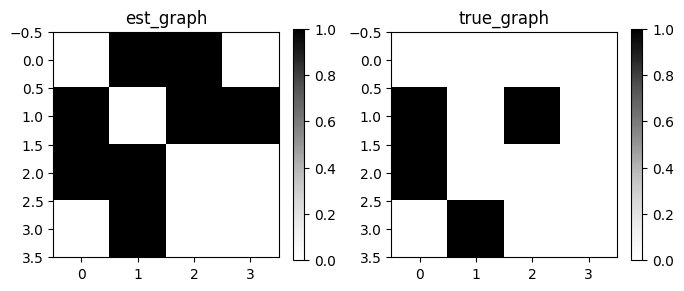

In [11]:
from castle.common import GraphDAG

# 学習した因果構造と真の因果構造を可視化して比較
GraphDAG(g.causal_matrix, true_dag, "result")

# 出力結果の見方
# 縦軸: 原因(矢印の元)、
# 横軸: 結果(矢印の矢じり)
# 黒色の部分にエッジがある
# 例) (1, 2)の箇所が黒色の場合、エッジは(1 → 2)

#### Step 5 精度検証



In [12]:
# 精度検証
from castle.metrics import MetricsDAG

# 学習した因果構造と真の因果構造との間の各種精度指標を計算
mt = MetricsDAG(g.causal_matrix, true_dag)
print(mt.metrics)  # noqa: T201


{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 4, 'precision': 0.5, 'recall': 1.0, 'F1': 0.6667, 'gscore': 0.0}


例えばF1を見ると0.6667と低く、因果構造も一致していないので改善の余地がある。

#### GES

スコアベースのGESアルゴリズムを実装

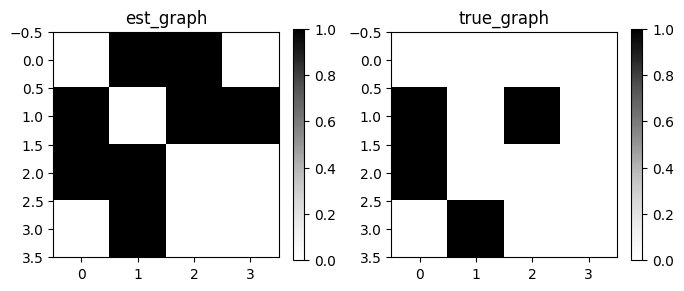

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 4, 'precision': 0.5, 'recall': 1.0, 'F1': 0.6667, 'gscore': 0.0}


In [13]:
# GESアルゴリズム

from castle.algorithms.ges.ges import GES

# 構造学習(GES).

# モデルの適合度評価にベイズ情報量規準(BIC)を使用
g = GES(criterion="bic")
g.learn(X)

# 予測・精度検証
GraphDAG(g.causal_matrix, true_dag)
m1 = MetricsDAG(g.causal_matrix, true_dag)
print(m1.metrics)  # noqa: T201


#### ICALiNGAM

因果関数モデルのICALiNGAMを実装

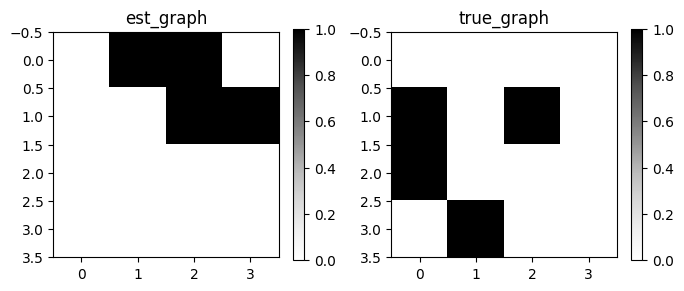

{'fdr': 0.75, 'tpr': 0.25, 'fpr': 1.5, 'shd': 3, 'nnz': 4, 'precision': 0.25, 'recall': 0.25, 'F1': 0.25, 'gscore': 0.0}


In [14]:
# ICALiNGAM
from castle.algorithms import ICALiNGAM

# 構造学習(ICALiNGAM).
g = ICALiNGAM(random_state=2)
g.learn(X)

# 予測・精度検証
GraphDAG(g.causal_matrix, true_dag)
met = MetricsDAG(g.causal_matrix, true_dag)
print(met.metrics)  # noqa: T201


#### GOLEM

勾配ベースのGOLEMを実装

2024-10-20 12:37:19,320 - /Users/sean/Documents/myscript/causal-inference-basic-book/notebook/chap7_8/.venv/lib/python3.11/site-packages/castle/algorithms/gradient/notears/torch/golem.py[line:122] - INFO: GPU is unavailable.


2024-10-20 12:37:19,375 - /Users/sean/Documents/myscript/causal-inference-basic-book/notebook/chap7_8/.venv/lib/python3.11/site-packages/castle/algorithms/gradient/notears/torch/golem.py[line:207] - INFO: Started training for 10000 iterations.
2024-10-20 12:37:19,378 - /Users/sean/Documents/myscript/causal-inference-basic-book/notebook/chap7_8/.venv/lib/python3.11/site-packages/castle/algorithms/gradient/notears/torch/golem.py[line:220] - INFO: [Iter 0] score=17.882, likelihood=17.882, h=0.0e+00
2024-10-20 12:37:22,179 - /Users/sean/Documents/myscript/causal-inference-basic-book/notebook/chap7_8/.venv/lib/python3.11/site-packages/castle/algorithms/gradient/notears/torch/golem.py[line:220] - INFO: [Iter 5000] score=15.319, likelihood=15.208, h=2.6e-04
2024-10-20 12:37:25,085 - /Users/sean/Documents/myscript/causal-inference-basic-book/notebook/chap7_8/.venv/lib/python3.11/site-packages/castle/algorithms/gradient/notears/torch/golem.py[line:220] - INFO: [Iter 10000] score=15.319, likelih

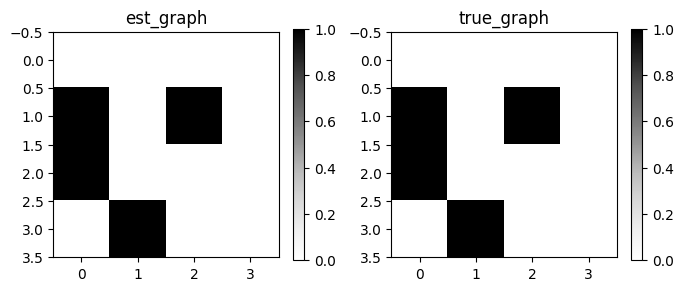

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 4, 'precision': 1.0, 'recall': 1.0, 'F1': 1.0, 'gscore': 1.0}


In [15]:
# GOLEM
from castle.algorithms import GOLEM

# 構造学習(GOLEM).
# num_iter: アルゴリズムの反復回数.
g = GOLEM(num_iter=1e4)
g.learn(X)

# 予測・精度検証
GraphDAG(g.causal_matrix, true_dag)
met = MetricsDAG(g.causal_matrix, true_dag)
print(met.metrics)  # noqa: T201


今回はGOLEMが最も精度が高かった。データセットによって向き不向きがあるため、複数を比較する事が多い。

## 8.4 時系列を伴う因果探索の全体像

時系列を考慮した因果探索は、社会科学、気候科学、生物学、ネットワークシステムなど多くの科学分野で重要。

時系列を考慮した因果探素の目的: 複数の時系列間の直接的な依存関係や共通の要因を識別する

多変量時系列からタイムラグを含む因果構造を推定する問題について、その基礎となる因果関係の仮定から実用例まで整理する。

### 8.4.1 時系列を伴う因果探索の概要

ここでは、
$X_i$について、異なる時刻$t, s$において、それぞれの時点における$X_i$を$X_{t, i}, X_{s,i}$として表記します。

時系列を伴う因果探索アルゴリズムの仮定
1. 時間的優先性(Temporal Priority)
    
    原因と結果の時間的関係として、結果より、原因の発生が先であること。
    
    しかし、時系列データの分析ではデータの粒度が大きいと、この関係は必ずしも明確に観察できるわけではない。例えば、データ1時点が1日分のデータを示す場合、その日のうちに原因と結果が起こっていると、どちらが先に起こったかの情報は含まれない。これを、瞬時の因果関係(Instantaneous causal relations)もしくは同時期の因果関係(Contemporaneous causal relations)という。

    なのでデータ収集の間隔は重要だが、この問題で現象の根本原因がわからない場合は、因果探索の中で同時点$t$における因果の方も推定するよう組み立てる必要がある。

2. 時間全体の一貫性(Consistency Throughout Time)
   
   原因と結果の因果関係が、時間が経っても変化しないこと。
   
   時間全体の一貫性がある場合、$X_{t, i}$と$X_{t+k, i}$の関係は、どの時点$t$で同じ。
   
   
* 上記の仮定を踏まえた、因果探索のアプローチ

時系列データを扱った因果探索も制約ベース、スコアベース、関数因果モデル、勾配ベースの代表的な4種に分類される。

|      | 1.制約ベース | 2.スコアベース | 3.関数因果モデル<br>(非ガウス性、非線形性の活用) |            4. 勾配ベース             |
| :--: | :----------: | :------------: | :----------------------------------------------: | :----------------------------------: |
| 静的 |   PC, FCI    |   GES, TTPM    |            LiNGAM, PNL,<br>ANM, HPCI             | NOTEARS, NOTEARS-GOLEM,<br>GAE, CORL |
| 動的 |    PCMCI     |    SVAR-FCI    |                    VAR-LiNGAM                    |              DYNOTEARS               |

PCMCIで時系列の因果探索のイメージを掴む。他のVAR-LiNGAM、DYNOTEARS、SVAR-FCIは簡単な説明に留める。

### 8.4.2 制約ベース: PCMCIの概要

* PCMCI(Peter and Clark Momentary Conditional Independence)
    * 気候データを扱った研究などで使用される
    * サンプルサイズが数百以上の場合や、線形および非線形の時点遅れ(Time lagged)の依存関係のあるデータセットに適している手法
    * 地球科学分野などの複雑な動的システムを扱う分野では、データセットが高次で非線形かつ、サンプルサイズが大きい

PCMCIは次の2つのアルゴリズムで構成されている。

1. PC<sub>1</sub>アルゴリズム
   
   [8.2.1項](#821-制約ベース)で出てきたPCアルゴリズム(PC-stable)を時系列に適応したもの。
   
   各変数の依存関係を確認するため、このアルゴリズムを使用して原因(親ノード)の候補を探す。

   ![図8.25](images/chap8/image-12.png)

   $X_{t, 1}$、と$X_{t, 3}$(それぞれ$X_1,X_3$の行の●のノード)を対象として説明。
   1. 1回目: 相関がないなど、条件付けのない場合に依存関係もないノードを除去(図中ではノードの色が濃いほうが相関が強い)
   2. 2回目以降: 条件付き独立の検定を行い、特定の条件下で依存関係のないノードを除去
   3. これを条件付き独立の検定を行う条件がなくなるまで繰り返すことで、原因の可能性の高いノード候補を探す(■と◆)、ただし、偽陽性(★マークのある■、◆)も含まれる可能性がある

2. MCI(瞬間的条件付き独立性: Momentary conditional Independence)検定
   
   PC<sub>1</sub>アルゴリズムで検出された偽陽性のノードを除外していく
   
   1. ある時点での2つのノードがその親ノードに条件づけられた状況で互いに独立であるか検証。
      条件付き独立ではない場合、つまり関連がある場合を数式で表現すると以下となる。
      $$
      X_{t - \tau, i} \not\perp X_{t, j} | parent(X_{t, j}) \backslash \{X_{t-\tau, i}\}, parent(X_{t-\tau, i})
      $$
      * $parent(X_{t, j})、parent(X_{t-\tau, i})$: $X_{t, j}、X_{t-\tau, i}$の親ノード
      * $parent(X_{t, j}) \backslash \{X_{t-\tau, i}\}$: $X_{t-\tau, i}$を除いた最大のタイムラグ$\tau$までの$X_{t,j}$の親ノード
      
      図8.25(右図)の例では、$X_{t-2, 1} \to X_{t, 3}$を当てはめて以下の式で検定する。
      $$
      X_{t-2, 1} \not\perp X_{t, 3} | parent(X_{t, 3})\backslash \{X_{t-2, 1}\}, parent(X_{t-2, 1})
      $$
      
      上式の結果は、
      $$
      parent(X_{t, 3}) \backslash \{X_{t-2, 1}\}: X_{t-2, 2}\\
      parent(X_{t-2, 1}): X_{t-3, 1}, X_{t-3, 2}
      $$
      となり、偽陽性のノードが候補から除外される。

PCMCIの発展として、PCMCI+がある。
* PMCIの拡張
* PMCIより効率的、かつご検出が少ない
* 同時期の因果関係の可能性も検出可(PMCIは時点遅れの因果関係のみ)

LPMCIもある。(潜在的な交絡因子を扱える)


### 8.4.3 関数因果モデル：VAR-LiNGAMの概要

LiNGAMをベクトル自己回帰モデル(Vector autoregression: VAR)と組み合わせて時系列に拡張したもの。

仮定として、LINGAMと同様に以下の4つを設定。

1. 誤差変数は非ガウス分布

   因果の方向をデータの分布から特定するために必要

   具体的に、XとYの例で考える。このとき因果方向は$X \to Y$(XをYに回帰する場合), $X \gets Y$(YをXに回帰する場合)の2通り考えられる。

   両方に対し、誤差分布をガウス分布と連続一様分布の2パターン設定してプロットした結果が下図である。

   ![図8.16](images/chap8/image-6.png)

   ガウス分布のパターンの比較では、残差$\hat{\varepsilon}_Y, \hat{\varepsilon}_X$の分布は同じだが、下段の連続一様分布では$X \gets Y$(右図)の残差$\hat{\varepsilon}_X$の分布がYの値によって変化している。

   このように、連続一様分布(もしくは他の非ガウス分布)で非対称性が現れるため、因果方向を特定可能。
2. 線形の構造方程式モデル
3. 非巡回性(これまでの手法と同様にDAGであること)
4. 隠れた共通原因なし(No hidden common causes: 2つ以上の観測変数に影響を与える未観測変数が存在しないこと)

* 従来のVAR: 時点遅れの因果関係のみを分析
* VAR-LiNGAM: 時点遅れの因果関係と同時期の因果関係の両方を分析可能

実行手順

複数の時系列データが互いに影響を及ぼすモデルを以下のように表現

$$
\begin{align}
X_t
&= A_0 X_t + A_1 X_{t-1} + A_2 X_{t-2} + \cdots + A_\tau X_{t-\tau} + \varepsilon_t \nonumber \\
&= \sum_{k=0}^\tau A_k X_{t-k} + \varepsilon_t \nonumber
\end{align}
$$

* $X_t$: 時点$t$での多変量時系列データ
* $A_k$: k時点遅れの係数行列
* $\varepsilon(t)$: 時点$t$での誤差項

ここで、$k$の値で場合分けをすると、
* $k = 1 \sim \tau$ ($\tau$: 最大タイムラグ)の場合: VARに適用
* $k = 0$の場合: VARモデルとデータの残差にLiNGAMを適用

詳細な分析過程は、元論文(Hyvarinen et al. 2010)を参照。

### 8.4.4 その他のモデルの概要

1. DDYNOTEARS

これまでの手法と同様に、時点遅れの因果関係と同時期の因果関係に両方について、多変量時系列の変数間の関係を分析。

構造ベクトル自己回帰モデル(SVAR)などを使用し、変数間の関係の時変構造を定式化。そして、非巡回性を仮定したうえでNO TEARSアルゴリズムを使用して、各変数間の関係を推定。

2. SVAR-FCI

SVARモデルとFCIモデルを組み合わせたもの。

* SVAR: 上記のDYNOTEARSで説明した構造ベクトル自己回帰モデル
* FCI: 潜在的な交絡因子が存在する可能性がある場合において、よく知られた制約ベースの手法

SVAR-FCIでは、SVARモデルから得られた残差を使用してFCIアルゴリズムを適用し、因果構造を推定。潜在変数の存在を考慮しながら因果構造を学習できる。

3. その他

非線形性を仮定した手法の
* Convergent Cross-Mapping(CCM)
* Pairwise Asymmetric Inference(PAI)

時系列を伴う因果探索アルゴリズムは、使用するデータセット次第でその推定精度は大きく変わるので、複数のアルゴリズムを試し、精度の高いものを選択することが多い。

## 8.5 時系列を伴う因果探索の実装

PCMCI+を用いて実装を行う。

問題設定: 地球科学のデータにおいて3つの変数の時系列データを取得できたとして、3つの変数間にどのような因果関係があるか?

#### Step 1 ライブラリの準備

PMCI関連のライブラリのtigramiteを使用する。

#### Step 2 データの準備


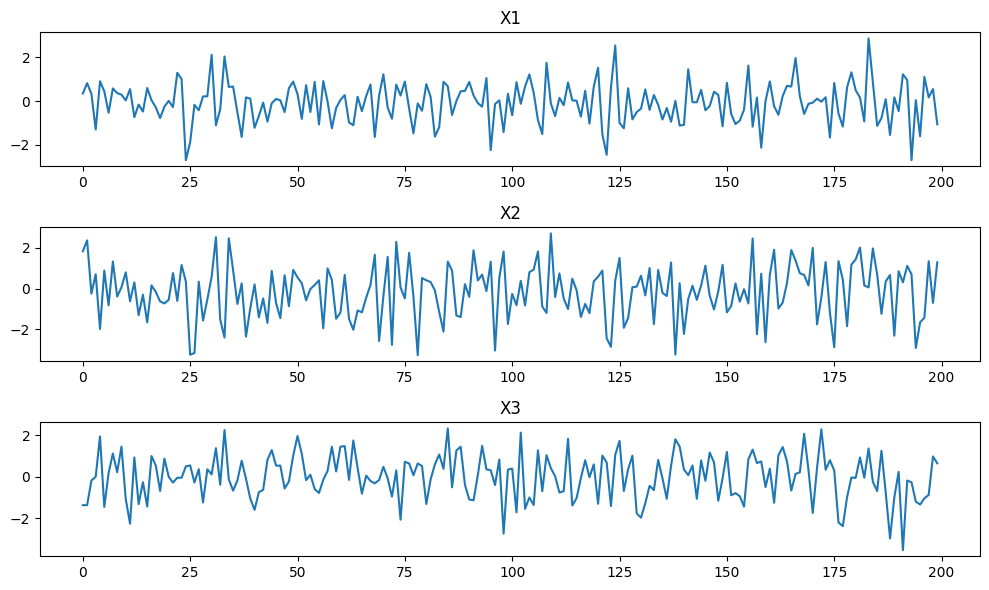

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# サンプルデータの生成
rng = np.random.default_rng(seed=1)
data_length = 200

# X1はノイズから生成
X1 = rng.standard_normal(data_length)

# X2はX1の1時点前のデータに依存し、1.0倍の値を持つ
X2 = np.empty(data_length)
X2[0] = rng.standard_normal()
for t in range(1, data_length):
    X2[t] = 1.0 * X1[t - 1] + rng.standard_normal()

# X3はX2の2時点前のデータに依存し、0.2倍の値を持つ
X3 = np.empty(data_length)
X3[0] = X3[1] = rng.standard_normal()
for t in range(2, data_length):
    X3[t] = 0.2 * X2[t - 2] + rng.standard_normal()

data = np.column_stack([X1, X2, X3])

# データの可視化
xiables = [X1, X2, X3]
titles = ["X1", "X2", "X3"]
plt.figure(figsize=(10, 6))
for i, (x, title) in enumerate(zip(xiables, titles, strict=True)):
    plt.subplot(3, 1, i + 1)
    plt.plot(x)
    plt.title(title)

plt.tight_layout()
plt.show()

#### Step 3 構造学習

In [2]:
from tigramite import data_processing as pp
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.pcmci import PCMCI

# DataFrameオブジェクトの作成
dataframe = pp.DataFrame(data)

# ParCorrを使用してPCMCI+をインスタンス化
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(significance="analytic"))

# 最小のラグを0(同時期の因果関係も考慮)、
# 最大のラグを2とし、
# PC1アルゴリズムの有意水準を0.05に設定
results = pcmci.run_pcmciplus(tau_min=0, tau_max=2, pc_alpha=0.05)

#### Step 4 実行結果の可視化

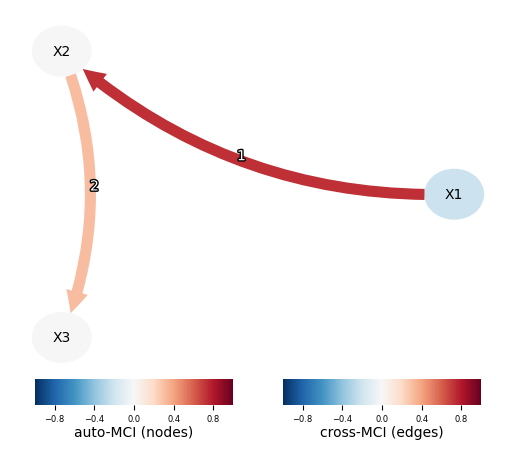

In [3]:
from tigramite import plotting as tp

tp.plot_graph(
    val_matrix=results["val_matrix"],
    graph=results["graph"],
    var_names=["X1", "X2", "X3"],
    link_colorbar_label="cross-MCI (edges)",
    node_colorbar_label="auto-MCI (nodes)",
)
plt.show()

図の
* 上側: 各ノードとその依存関係
* 下側
    * auto-MCI: 各ノードの自己相関のつよさ
    * cross-MCI: 各エッジの相互依存関係の強さ

つまり、
* X3は、X2からタイムラグ2で正の弱い影響(薄い赤色)を受けている
* X2は、X1からタイムラグ1で正の強い影響(濃い赤色)を受けている

## 8.6 因果探索の課題

1. 因果関係の推定精度の向上
   
   推定精度をより向上させるために、これまでのようなアプローチに加えて、
   * アンサンブル学習、大規模言語モデル(Large Language Model: LLM)を活用して因果関係を推定する方法
   * 強化学習との融合
   * 拡散モデルと組み合わせた方法
   * ベイズ最適化と組み合わせた方法
   
   など、これまでにない方法が開発されている。
   
   また、不規則な時系列データにも対応する方法も開発されている。

2. 膨大なデータの量と次元への対応
   
   たとえば、全世界の気候データの総量は、2010年の5PBから2030年には350PBに増加すると予測されている。
   
   このような高次元のデータを扱うために、効率的でスケーラブルな学習が提案されている。

3. その他
   
   第7章以前に説明してきた因果推論の手法と同様
   * 分布シフトへの対応
   * 測定誤差への対応
   * 選択バイアスへの対応
   * 異質性のあるデータへの対応

などが課題として存在。

##### メモ
因果探索を行ったうえで、因果推論まで一貫して行う方法が現在研究されていまる。これにより、究極的にはドメイン知識がなくても、因果探索を自動的に行いDAGが適切に推定できていれば、因果効果まで推定できるようになる。

おわりに
